### Location Variables

In [84]:
import os

data_dir = '~/Learn/ML/IR'
raw_data_dir = os.path.join(data_dir, 'raw')

### Hyperparameters

In [85]:
maxlen = 300
embedding_dim = 300
seed = 7
n_splits = 8
epochs = 14
batch_size=10

### Data Loading

In [87]:
import nltk
import re
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')

def norm_tweet(tweet):
    tweet = tweet.lower()
    pattern = r"[{}]".format(",.;@#!") 
    tweet = re.sub(pattern, "", str(tweet))
    tweet = tweet.strip()
    tokens = WPT.tokenize(tweet)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    tweet = ' '.join(filtered_tokens)
    return tweet

def load_raw_data():
    from pandas import read_csv
    train_data = read_csv(os.path.join(raw_data_dir, 'train.csv'))
    test_data = read_csv(os.path.join(raw_data_dir, 'test.csv'))
    cols = ['tweet', 'has_claim', 'has_checkworthy_claim', 'obj_subj']
    train_data = train_data[cols]
    train_data = train_data.replace(['-'], '0')
    train_data = train_data.fillna('0')
    test_data =  test_data[cols]
    test_data =  test_data.replace(['-'], '0')
    test_data = test_data.fillna('0')
    return train_data, test_data

def drop_half(df, col, val):
    not_val = df.index[df[col] == val].to_list()
    df = df.drop(not_val[:int(len(not_val)/2)])
    return df

def load_data():
    train, test = load_raw_data()
    train['has_checkworthy_claim'] = train['has_checkworthy_claim'].map(lambda x: float(x))
    train['tweet'] = train['tweet'].map(norm_tweet)
    train = train.dropna()
    test['has_checkworthy_claim'] = test['has_checkworthy_claim'].map(lambda x: float(x))
    test['tweet'] = test['tweet'].map(norm_tweet)
    test = test.dropna()
    ## Drop half of the not checkworthy data since data is unbalanced
#     train = drop_half(train, 'has_checkworthy_claim', 0)
#     train = drop_half(train, 'has_checkworthy_claim', 0)
#     test = drop_half(test, 'has_checkworthy_claim', 0)
#     test = drop_half(test, 'has_checkworthy_claim', 0)
    
#     train = train.append(train.loc[train['has_checkworthy_claim'] == 1])
    return train, test

train_data, test_data = load_data()
num_of_check_worthy = lambda d: d[d['has_checkworthy_claim'] == 1]['has_checkworthy_claim'].sum() 
print('TRAIN DATA: Number of checkworthy claims: {} Number of not checkworthy claims: {}'.format(num_of_check_worthy(train_data), len(train_data) - num_of_check_worthy(train_data)))
print('TEST DATA: Number of checkworthy claims: {} Number of not checkworthy claims: {}'.format(num_of_check_worthy(test_data), len(test_data) - num_of_check_worthy(test_data)))
test_data.to_csv('testBalanced.csv', encoding='utf-8')
train_data.to_csv('trainBalanced.csv', encoding='utf-8')

TRAIN DATA: Number of checkworthy claims: 123.0 Number of not checkworthy claims: 613.0
TEST DATA: Number of checkworthy claims: 36.0 Number of not checkworthy claims: 165.0


### Plotting Helper

In [88]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
def plot_history(history, idx):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('{}: Training and validation accuracy'.format(idx))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'bo', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('{}: Training and validation loss'.format(idx))
    plt.legend()

## Features & Pre Trained Word Embedding Matrix

In [89]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from flair.embeddings import WordEmbeddings, CharacterEmbeddings, StackedEmbeddings
from flair.data import Sentence, Token

np.random.seed(seed)

character_embeddings = CharacterEmbeddings()
fasttext_embedding = WordEmbeddings('tr-crawl')

stacked_embeddings = StackedEmbeddings(
    embeddings=[fasttext_embedding, character_embeddings])


def word_embedding(word):
    sentence = Sentence(word)
    stacked_embeddings.embed(sentence)
    return sentence[0].embedding.data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tweet'])
vocab_size = len(tokenizer.word_index) + 1

def create_embedding_matrix(embedder, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros(((vocab_size, embedding_dim)))
    for word, idx in word_index.items():
        embedding_matrix[idx] = embedder(word)[:embedding_dim]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(lambda w: word_embedding(w), tokenizer.word_index, embedding_dim)

### Keras Model

In [90]:
from keras.layers import *
from keras.models import *
from keras import optimizers
import keras.regularizers
from keras.initializers import Constant

## Biderectional LSTM model also uses other features
def create_keras_model():
    nlp_input = Input(shape=(maxlen,), name='nlp_input')
    meta_input = Input(shape=(2,), name='meta_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=False, embeddings_initializer=Constant(embedding_matrix))(nlp_input)
    nlp_out = Bidirectional(LSTM(128, dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
    x = concatenate([nlp_out, meta_input])
    x = Dense(8, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[nlp_input , meta_input], outputs=[x])
    model.compile(optimizer=optimizers.adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

##  CNN Model 
def create_seq_model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, embeddings_initializer=Constant(embedding_matrix),input_length=maxlen, trainable=False))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Cross Validation

Train on 643 samples, validate on 93 samples
Epoch 1/14
643/643 [==============================] - 22s 34ms/step - loss: 3.2903 - acc: 0.8180 - val_loss: 0.8838 - val_acc: 0.8280
Epoch 2/14
643/643 [==============================] - 16s 25ms/step - loss: 0.5699 - acc: 0.8336 - val_loss: 0.4798 - val_acc: 0.8280
Epoch 3/14
643/643 [==============================] - 18s 28ms/step - loss: 0.4592 - acc: 0.8336 - val_loss: 0.4471 - val_acc: 0.8172
Epoch 4/14
643/643 [==============================] - 17s 26ms/step - loss: 0.4598 - acc: 0.8320 - val_loss: 0.4461 - val_acc: 0.8280
Epoch 5/14
643/643 [==============================] - 18s 28ms/step - loss: 0.4379 - acc: 0.8336 - val_loss: 0.4238 - val_acc: 0.8280
Epoch 6/14
643/643 [==============================] - 18s 28ms/step - loss: 0.4390 - acc: 0.8336 - val_loss: 0.4379 - val_acc: 0.8280
Epoch 7/14
643/643 [==============================] - 18s 28ms/step - loss: 0.4386 - acc: 0.8336 - val_loss: 0.4129 - val_acc: 0.8280
Epoch 8/14
643/64

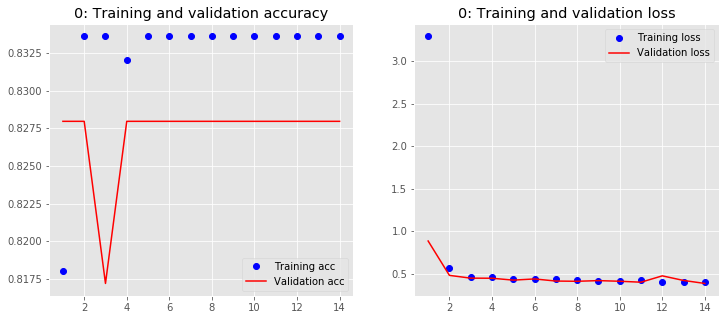

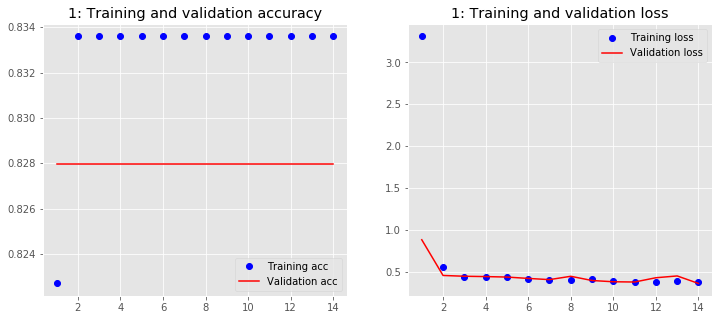

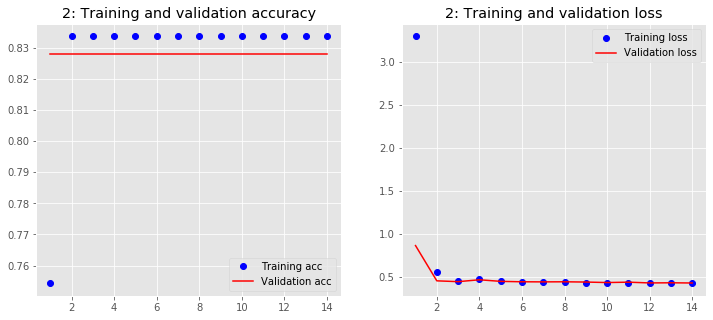

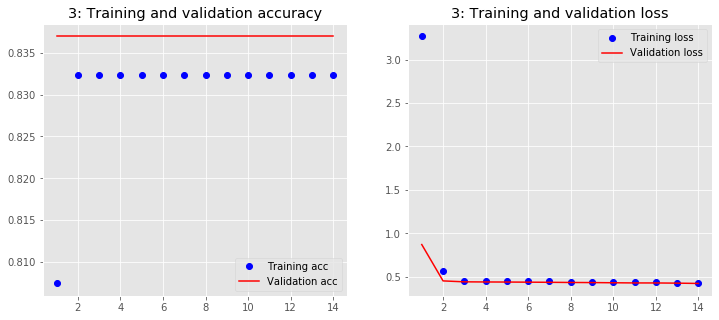

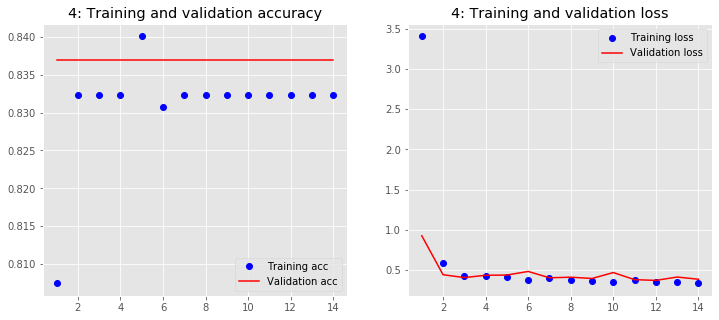

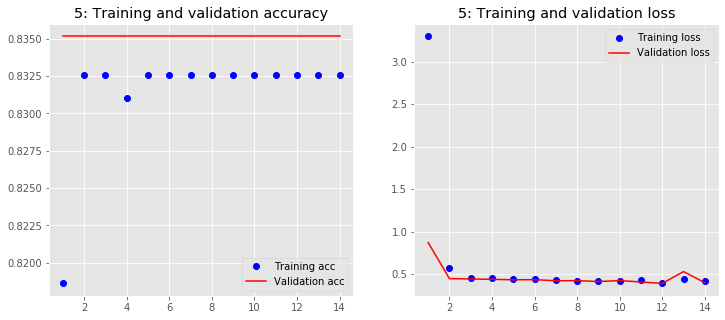

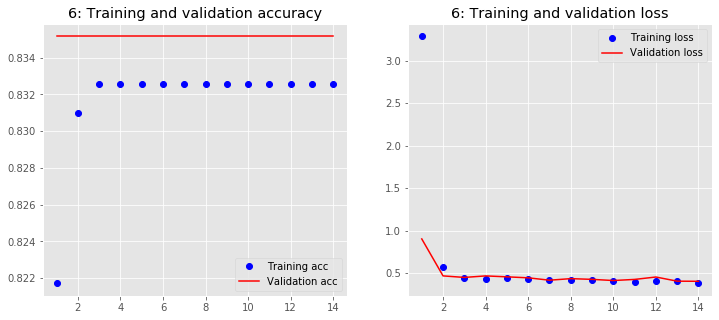

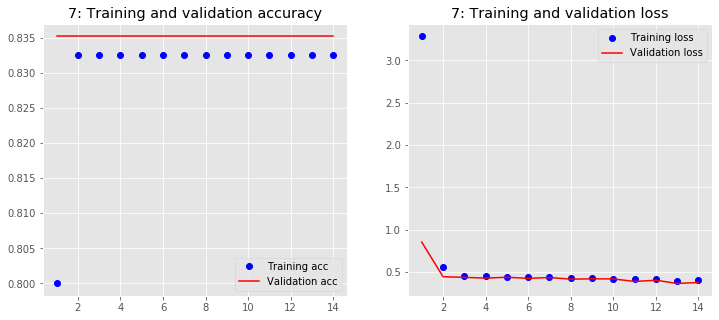

In [98]:
from sklearn.model_selection import StratifiedKFold


X = train_data['tweet']
Y = train_data['has_checkworthy_claim']

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
cvscores = []
histories = []

for train, test in kfold.split(X, Y):
    model = create_keras_model()
#     model = create_seq_model()
    X_train = pad_sequences(tokenizer.texts_to_sequences(X.iloc[train]), padding='post', maxlen=maxlen)
    X_test = pad_sequences(tokenizer.texts_to_sequences(X.iloc[test]), padding='post', maxlen=maxlen)
    y_train = Y.iloc[train]
    y_test = Y.iloc[test]
    X_train_obj = train_data['obj_subj'].iloc[train]
    X_train_has_claim = train_data['has_claim'].iloc[train]
    X_test_obj = train_data['obj_subj'].iloc[test]
    X_test_has_claim = train_data['has_claim'].iloc[test]
    arr = np.array([X_train_obj, X_train_has_claim]).T
    arr_test = np.array([X_test_obj, X_test_has_claim]).T
#     print(arr.shape)
    history = model.fit([X_train, arr], y_train, epochs=epochs, validation_data=([X_test, arr_test], y_test), batch_size=batch_size, verbose=True)
#     history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, verbose=True)
    histories.append(history)
    scores = model.evaluate([X_test, arr_test], y_test, verbose=0)
#     scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

for i, h in enumerate(histories):
    plot_history(h, i)

In [100]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['tweet']), padding='post', maxlen=maxlen)
X_test_obj = test_data['obj_subj']
X_test_has_claim = test_data['has_claim']
y_test = test_data['has_checkworthy_claim']
arr_test = np.array([X_test_obj, X_test_has_claim]).T
predicted = model.predict([X_test, arr_test])
# predicted = model.predict(X_test)
scores = model.evaluate([X_test, arr_test], y_test, verbose=1)
# scores = model.evaluate(X_test, y_test, verbose=1)

201/201 [==============================] - 1s 3ms/step


In [101]:
scores

[0.44255467315218344, 0.8208955232776812]

In [102]:
import pydot
from keras.utils import plot_model
plot_model(model, to_file='modelCNN.png')

In [103]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, list(map(lambda x: 1 if x > 0.5 else 0, model.predict([X_test, arr_test]))))

In [104]:
matrix

array([[165,   0],
       [ 36,   0]])

In [107]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(y_test.to_list(), list(map(lambda x: 1 if x > 0.5 else 0, predicted.reshape((201,)))))
cm.print_stats()

Confusion Matrix:

Predicted  0.0  1.0  __all__
Actual                      
0.0        165    0      165
1.0         36    0       36
__all__    201    0      201


Overall Statistics:

Accuracy: 0.8208955223880597
95% CI: (0.7607701154663274, 0.8712922012155326)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                     0.0       1.0
Population                                  201       201
P: Condition positive                       165        36
N: Condition negative                        36       165
Test outcome positive                       201         0
Test outcome negative                         0       201
TP: True Positive                           165         0
TN: True Negative                             0       165
FP: False Positive                           36         0
FN: False Negative                            0        36
TPR: (Sensitivity, hit rate, recall)       

array([[0.80908775],
       [0.02876422],
       [0.32219774],
       [0.48678118],
       [0.73477775],
       [0.49099353],
       [0.23627505],
       [0.8635146 ],
       [0.15014094],
       [0.06646982],
       [0.42678732],
       [0.5855154 ],
       [0.3206321 ],
       [0.15139735],
       [0.43312693],
       [0.43312693],
       [0.9484948 ],
       [0.8360257 ],
       [0.11236477],
       [0.7438222 ],
       [0.07313746],
       [0.2224479 ],
       [0.03263557],
       [0.0338555 ],
       [0.08792314],
       [0.858941  ],
       [0.10710132],
       [0.02818406],
       [0.1562371 ],
       [0.31466365],
       [0.04819047],
       [0.14731085],
       [0.05399871],
       [0.06817895],
       [0.05498135],
       [0.86281276],
       [0.32687113],
       [0.02724206],
       [0.8273971 ],
       [0.9279614 ],
       [0.14104414],
       [0.15032089],
       [0.27132714],
       [0.11255991],
       [0.06772482],
       [0.86544883],
       [0.0796113 ],
       [0.053